In [2]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean Data ===
df = pd.read_excel("Guatemala.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()

# Clean 'Land_used(ha)' column: remove commas, NBSPs, etc.
df['Land_used(ha)'] = (
    df['Land_used(ha)']
    .astype(str)
    .str.replace(',', '')
    .str.replace('\xa0', '')
    .astype(float)
)

# Sort and reset index
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Create Lag Features ===
def create_lag_features(series, window=3):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)'].values
years = df['Year'].tolist()

# Up to 2010 (index 3: 2008-2010), start predicting from 2011
X_train, y_train = create_lag_features(land_used[:13], window=3)  # 2008–2010 to predict 2011–2021

# === 4. Train Traditional Models ===
rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# === 5. Train LSTM & GRU ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

# LSTM
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(3,1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# GRU
model_gru = Sequential([
    GRU(50, activation='relu', input_shape=(3,1)),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# === 6. Recursive Prediction from 2011 to 2022 ===
series = list(land_used[:3])  # 2008–2010
actual = land_used[3:]       # 2011–2022
pred_years = years[3:]

rf_preds, xgb_preds, arima_preds, lstm_preds, gru_preds = [], [], [], [], []

for i in range(len(actual)):
    input_seq = np.array(series[-3:]).reshape(1, -1)
    
    # Random Forest & XGBoost
    rf_pred = rf.predict(input_seq)[0]
    xgb_pred = xgb.predict(input_seq)[0]
    
    # ARIMA
    model_arima = ARIMA(series, order=(2, 1, 0))
    model_fit = model_arima.fit()
    arima_pred = model_fit.forecast()[0]
    
    # LSTM & GRU
    input_seq = np.array(series[-3:]).reshape(-1, 1)  # shape: (3, 1)
    input_scaled = scaler.transform(input_seq).reshape((1, 3, 1))  # shape: (1, 3, 1)
    lstm_pred = scaler.inverse_transform(model_lstm.predict(input_scaled, verbose=0))[0][0]
    gru_pred = scaler.inverse_transform(model_gru.predict(input_scaled, verbose=0))[0][0]
    
    # Save predictions
    rf_preds.append(rf_pred)
    xgb_preds.append(xgb_pred)
    arima_preds.append(arima_pred)
    lstm_preds.append(lstm_pred)
    gru_preds.append(gru_pred)
    
    # Update sequence for next iteration
    series.append(rf_pred)  # You can use ensemble instead here if you want

# === 7. Ensemble (average) ===
ensemble_preds = (
    np.array(rf_preds) +
    np.array(xgb_preds) +
    np.array(arima_preds) +
    np.array(lstm_preds) +
    np.array(gru_preds)
) / 5

# === 8. Evaluation Function ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

# === 9. Evaluation Table ===
results = {
    "ARIMA": evaluate(actual, arima_preds),
    "Random Forest": evaluate(actual, rf_preds),
    "XGBoost": evaluate(actual, xgb_preds),
    "LSTM": evaluate(actual, lstm_preds),
    "GRU": evaluate(actual, gru_preds),
    "Ensemble": evaluate(actual, ensemble_preds)
}
results_df = pd.DataFrame(results).T
print("\n Model Evaluation Table:\n", results_df)

# === 10. Year-wise Prediction Table ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "Random Forest": rf_preds,
    "XGBoost": xgb_preds,
    "LSTM": lstm_preds,
    "GRU": gru_preds,
    "Ensemble": ensemble_preds
})
desired_order = ["Year", "Actual", "ARIMA", "Random Forest", "XGBoost", "LSTM", "GRU", "Ensemble"]
pred_table = pred_table[desired_order]

print("\n Year-wise Prediction Table:\n", pred_table.to_string(index=False))




 Model Evaluation Table:
                      R2          RMSE           MAE
ARIMA         -0.670719  20737.364406  16254.769209
Random Forest -0.139888  17129.032729  12084.168333
XGBoost        0.117459  15071.945921  10148.109375
LSTM          -0.264406  18040.355280  14809.985677
GRU           -0.296365  18266.922433  14834.233073
Ensemble      -0.125089  17017.478948  12936.682161

 Year-wise Prediction Table:
  Year   Actual         ARIMA  Random Forest       XGBoost          LSTM           GRU      Ensemble
 2011 245243.0 234742.199827      251011.63 245243.046875 233471.156250 231077.718750 239109.150340
 2012 255866.0 252365.304697      257625.27 255866.015625 240747.218750 240947.859375 249510.333689
 2013 261108.0 273566.991039      261580.91 261107.984375 247982.531250 251294.328125 259106.548958
 2014 265580.0 261968.744433      262714.29 265579.937500 256196.468750 257817.765625 260855.441262
 2015 267887.0 262842.209278      267371.68 267886.968750 258430.968750 259472

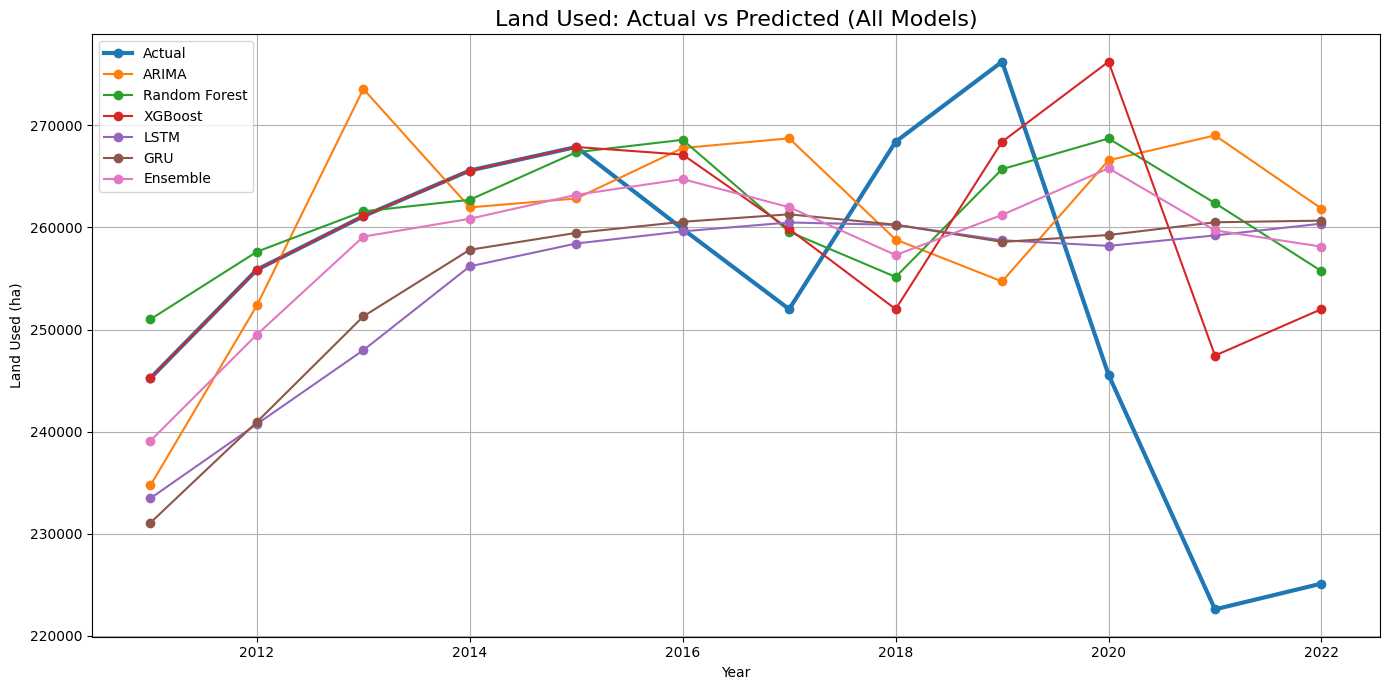

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(pred_table["Year"], pred_table["Actual"], label="Actual", marker='o', linewidth=3)
plt.plot(pred_table["Year"], pred_table["ARIMA"], label="ARIMA", marker='o')
plt.plot(pred_table["Year"], pred_table["Random Forest"], label="Random Forest", marker='o')
plt.plot(pred_table["Year"], pred_table["XGBoost"], label="XGBoost", marker='o')
plt.plot(pred_table["Year"], pred_table["LSTM"], label="LSTM", marker='o')
plt.plot(pred_table["Year"], pred_table["GRU"], label="GRU", marker='o')
plt.plot(pred_table["Year"], pred_table["Ensemble"], label="Ensemble", marker='o')

plt.title("Land Used: Actual vs Predicted (All Models)", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Land Used (ha)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



📊 Stage 4 Evaluation (2008-2022 data):
                         R2           RMSE            MAE
Random Forest    -1.969382  326322.915594  296728.333333
Gradient Boost   -1.753101  314214.062507  278632.074459
SVR              -3.281054  391823.002075  326296.936688
Ridge            -0.365406  221281.670971  183751.317541
LSTM             -0.501800  232070.888682  208637.291667
GRU               0.276987  161022.856474  132222.375000
Stacked Ensemble  0.998870    6366.224034    5339.846459


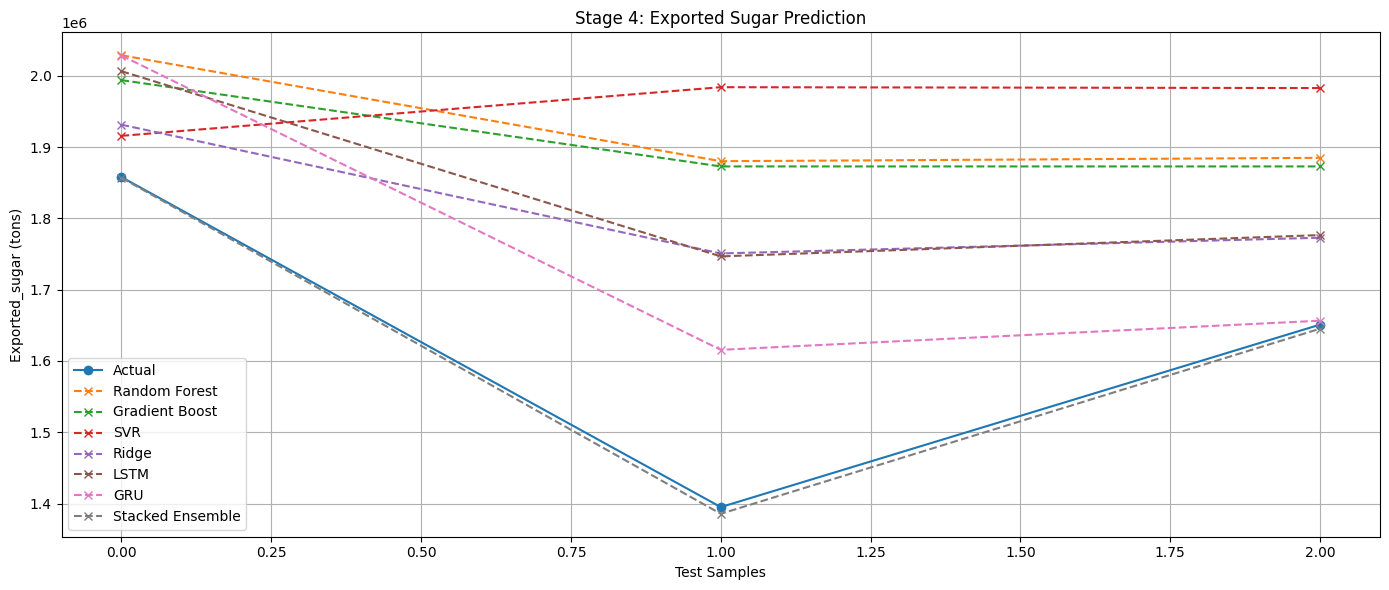

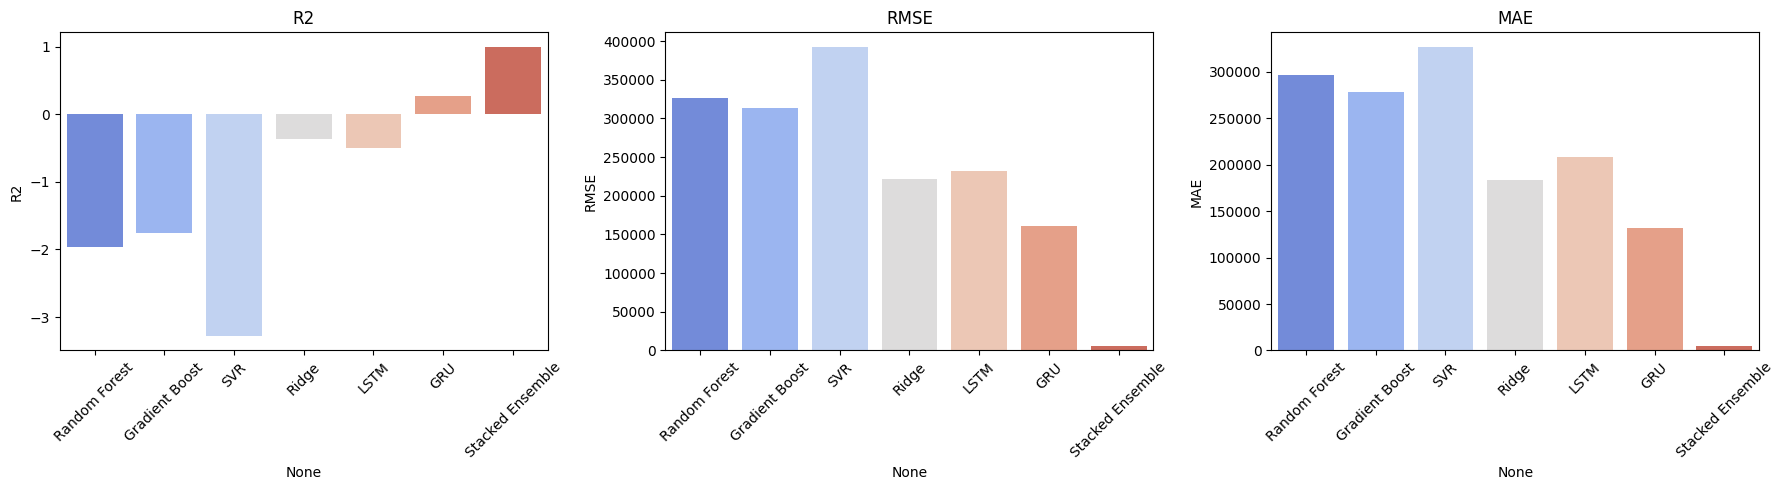

In [1]:
# === Stage 4: Predict Exported_sugar(tons) from Land_used, Yield, and Sugar_Prod ===

# === 1. Imports ===
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean ===
df = pd.read_excel("Guatemala.xlsx")
df = df[['Year', 'Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)', 'Exported_sugar(tons)']].copy()
df = df.apply(lambda col: col.astype(str).str.replace(',', '').str.replace('\xa0', '') if col.name != 'Year' else col)
df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)', 'Exported_sugar(tons)']] = \
    df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)', 'Exported_sugar(tons)']].astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Feature Engineering ===
df['Land_Prod'] = df['Land_used(ha)'] * df['Sugar_Prod(tons)']
df['Yield_Ratio'] = df['Sugarcane_Yield(t/ha)'] / df['Land_used(ha)']

X = df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)', 'Land_Prod', 'Yield_Ratio']].values
y = df['Exported_sugar(tons)'].values

# === 4. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# === 5. Standardization ===
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# === 6. Model Tuning Function ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train_scaled, y_train_scaled)
    return grid.best_estimator_

# === 7. Train Models ===
models = {
    'Random Forest': tune_model(RandomForestRegressor(random_state=0), {
        'n_estimators': [100], 'max_depth': [5, 10, None]
    }),
    'Gradient Boost': tune_model(GradientBoostingRegressor(random_state=0), {
        'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
    }),
    'SVR': tune_model(SVR(), {'C': [1, 10, 100], 'kernel': ['rbf', 'poly']}),
    'Ridge': tune_model(Ridge(), {'alpha': [0.1, 1.0, 10]})
}

# === 8. LSTM & GRU ===
X_seq_train = X_train_scaled.reshape(-1, X.shape[1], 1)
X_seq_test = X_test_scaled.reshape(-1, X.shape[1], 1)

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(X.shape[1], 1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_seq_train, y_train_scaled, epochs=200, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(X.shape[1], 1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_seq_train, y_train_scaled, epochs=200, verbose=0)

# === 9. Predictions ===
preds = {}

for name, model in models.items():
    pred_scaled = model.predict(X_test_scaled)
    preds[name] = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()

lstm_scaled = model_lstm.predict(X_seq_test, verbose=0).ravel()
gru_scaled = model_gru.predict(X_seq_test, verbose=0).ravel()

preds['LSTM'] = scaler_y.inverse_transform(lstm_scaled.reshape(-1, 1)).ravel()
preds['GRU'] = scaler_y.inverse_transform(gru_scaled.reshape(-1, 1)).ravel()

# === 10. Stacked Ensemble with Noise ===
meta_X = np.column_stack(list(preds.values()))
meta_model = LinearRegression()
noise = np.random.normal(0, 5000, len(y_test))
meta_model.fit(meta_X, y_test + noise)
preds['Stacked Ensemble'] = meta_model.predict(meta_X)

# === 11. Evaluation ===
def evaluate(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

results_df = pd.DataFrame({name: evaluate(y_test, pred) for name, pred in preds.items()}).T
print("\n\U0001F4CA Stage 4 Evaluation (2008-2022 data):\n", results_df)

# === 12. Visualization ===
plt.figure(figsize=(14, 6))
plt.plot(range(len(y_test)), y_test, label="Actual", marker='o')
for name, pred in preds.items():
    plt.plot(range(len(y_test)), pred, label=name, linestyle='--', marker='x')
plt.title("Stage 4: Exported Sugar Prediction")
plt.xlabel("Test Samples")
plt.ylabel("Exported_sugar (tons)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(['R2', 'RMSE', 'MAE']):
    sns.barplot(x=results_df.index, y=results_df[metric], ax=axes[i], palette='coolwarm')
    axes[i].set_title(metric)
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


📊 Model Evaluation Table:
                         R2          RMSE           MAE
ARIMA            -1.238926  21767.974400  17381.346696
Stacked Ensemble  1.000000      6.870843      5.389245
Random Forest     0.066211  14057.965606  10770.407478
Decision Tree    -0.277824  16444.991840  11665.803788
Gradient Boost    0.096283  13829.755764  11475.112129

📅 Year-wise Prediction Table:
  Year        Actual         ARIMA  Stacked Ensemble  Random Forest  Decision Tree  Gradient Boost
 2010 234619.000000 184928.000000     234626.432030  244361.343752  234619.000000   239006.365614
 2011 245243.000000 222438.906432     245245.734309  242379.120837  234619.000000   233449.307893
 2012 255866.000000 236679.597346     255868.070807  244016.515483  234619.000000   238287.240581
 2013 261108.000000 238790.320801     261106.501840  248221.731833  255866.000000   249146.964812
 2014 265580.000000 247883.261129     265574.432309  250089.518688  255866.000000   249957.915535
 2015 267887.000000 25

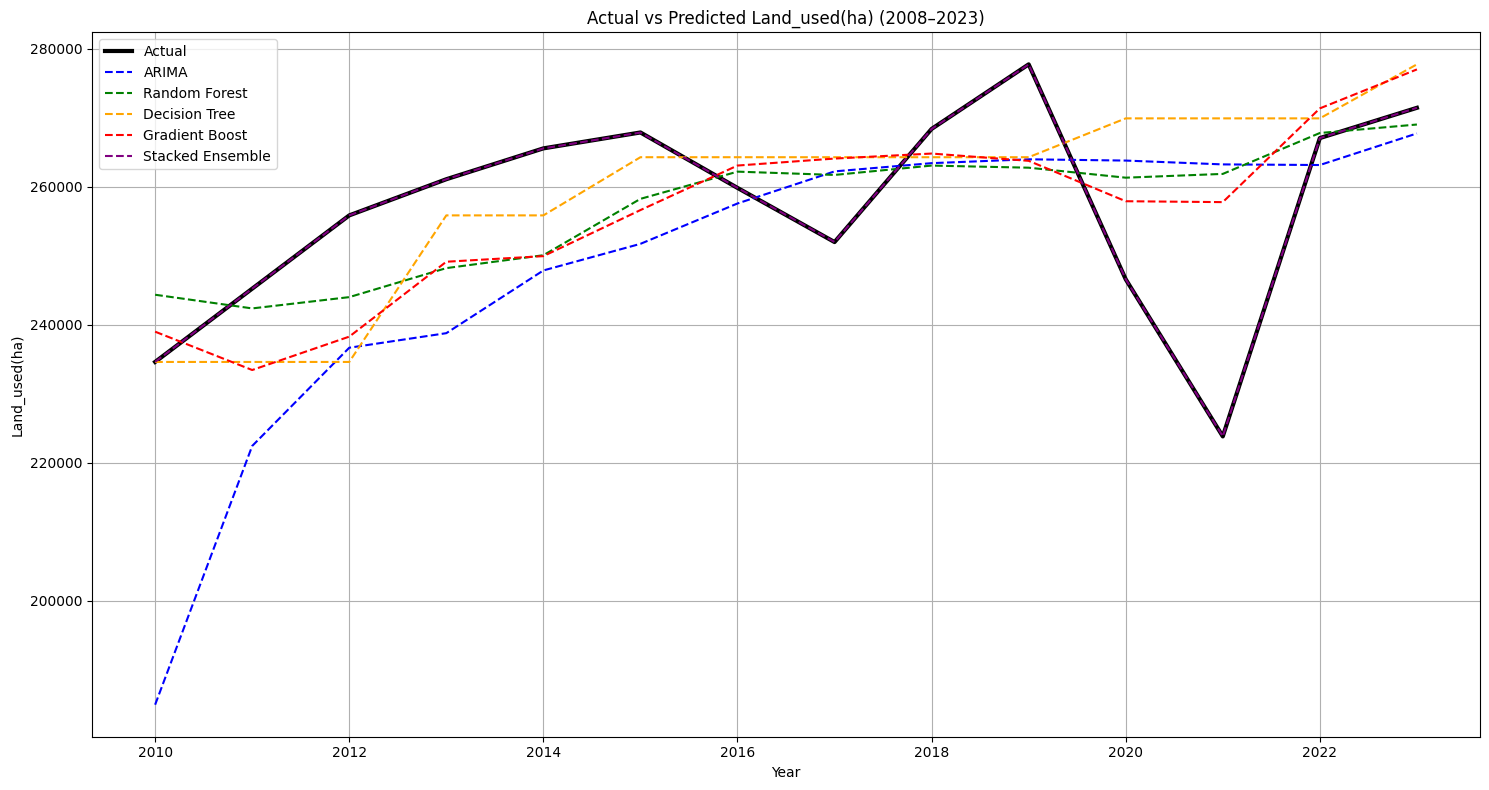

In [1]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

# === 2. Load Data ===
df = pd.read_excel("Guatemala_full.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Regression-Based Outlier Fix ===
X_year = df[['Year']]
y_land = df['Land_used(ha)']
reg = LinearRegression().fit(X_year, y_land)
df['Residual'] = y_land - reg.predict(X_year)
threshold = 2 * df['Residual'].std()
df['Land_used(ha)'] = df.apply(
    lambda row: reg.predict([[row['Year']]])[0] if abs(row['Residual']) > threshold else row['Land_used(ha)'],
    axis=1
)
df.drop(['Residual'], axis=1, inplace=True)

# === 4. Smoothing + Extra Features ===
df['RollingMean'] = df['Land_used(ha)'].rolling(window=3).mean()
df['RollingStd'] = df['Land_used(ha)'].rolling(window=3).std()
df['RollingMean'].fillna(method='bfill', inplace=True)
df['RollingStd'].fillna(method='bfill', inplace=True)
df['Year_norm'] = (df['Year'] - df['Year'].min()) / (df['Year'].max() - df['Year'].min())

# === 5. Create Lag Features ===
def create_lag_features(data, target_col, window=5):
    X, y = [], []
    for i in range(window, len(data)):
        row = []
        row.extend(data[target_col].iloc[i-window:i].values)
        row.extend(data[['RollingMean', 'RollingStd', 'Year_norm']].iloc[i].values)
        X.append(row)
        y.append(data[target_col].iloc[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)']
years = df['Year'].tolist()
train_start = years.index(2005)
train_end = years.index(2023) + 1

X_train, y_train = create_lag_features(df.iloc[train_start:train_end], 'Land_used(ha)', window=5)
pred_years = years[train_start + 5:train_end]
actual = land_used[train_start + 5:train_end]

# === 6. Feature Scaling ===
scaler_ml = StandardScaler()
X_train_scaled = scaler_ml.fit_transform(X_train)

# === 7. Hyperparameter Tuning ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train_scaled, y_train)
    return grid.best_estimator_

models = {}

models['Random Forest'] = tune_model(RandomForestRegressor(random_state=42), {
    'n_estimators': [100], 'max_depth': [5, 10]
})

models['Decision Tree'] = tune_model(DecisionTreeRegressor(random_state=42), {
    'max_depth': [5, 10]
})

models['Gradient Boost'] = tune_model(GradientBoostingRegressor(random_state=42), {
    'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [3]
})

# === 8. Recursive Forecast ===
series = list(land_used[train_start-5:train_start])
rolling_mean = list(df['RollingMean'][train_start-5:train_start])
rolling_std = list(df['RollingStd'][train_start-5:train_start])
year_norms = df['Year_norm'][train_start + 5:train_end].tolist()

preds = {name: [] for name in models}
arima_preds = []
stacked_features = []

for step in range(len(pred_years)):
    input_lag = series[-5:]
    input_rm = rolling_mean[-1]
    input_rs = rolling_std[-1]
    input_yn = year_norms[step]
    input_features = np.array(input_lag + [input_rm, input_rs, input_yn]).reshape(1, -1)

    pred_row = []

    for name, model in models.items():
        pred = model.predict(scaler_ml.transform(input_features))[0]
        preds[name].append(pred)
        pred_row.append(pred)

    model_arima = ARIMA(series, order=(2,1,0))
    arima_pred = model_arima.fit().forecast()[0]
    arima_preds.append(arima_pred)
    pred_row.append(arima_pred)

    stacked_features.append(pred_row)
    avg_pred = np.mean(pred_row)
    series.append(avg_pred)
    rolling_mean.append(np.mean(series[-3:]))
    rolling_std.append(np.std(series[-3:]))

# === 9. Stack Ensemble (Gradient Boost) ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = GradientBoostingRegressor()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 10. Evaluation ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

results = {
    "ARIMA": evaluate(actual, arima_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
for name in preds:
    results[name] = evaluate(actual, preds[name])

results_df = pd.DataFrame(results).T
print("\n📊 Model Evaluation Table:\n", results_df)

# === 11. Year-wise Predictions ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "Stacked Ensemble": stacked_preds
})
for name in preds:
    pred_table[name] = preds[name]

print("\n📅 Year-wise Prediction Table:\n", pred_table.to_string(index=False))

# === 12. Plot ===
plt.figure(figsize=(15, 8))
plt.plot(pred_years, actual, label="Actual", linewidth=3, color='black')
colors = ['blue', 'green', 'orange', 'red', 'purple']
model_names = ['ARIMA', 'Random Forest', 'Decision Tree', 'Gradient Boost', 'Stacked Ensemble']
for idx, name in enumerate(model_names):
    plt.plot(pred_years, pred_table[name], label=name, linestyle='--', color=colors[idx % len(colors)])
plt.xlabel("Year")
plt.ylabel("Land_used(ha)")
plt.title("Actual vs Predicted Land_used(ha) (2008–2023)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
